Programación Evolutiva
===

* 30:00 min | Última modificación: Mayo 19, 2021 | [YouTube]

## Función a minimizar

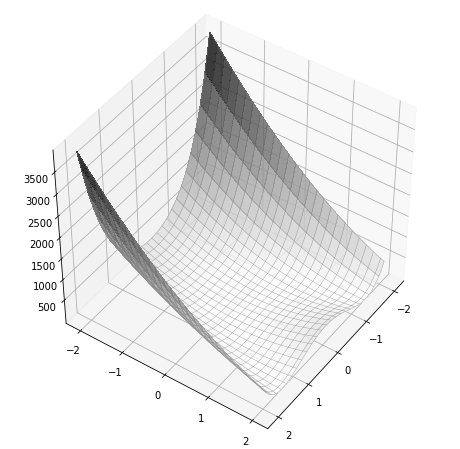

In [1]:
from EAOS.benchmarks import Ackley, Griewank, Rosenbrock

fn = Rosenbrock(n_dim=2)
fn.plot_surface()

## Algoritmo EP

En el algoritmo básico, el único operador existente es la mutación definida como:

$$
\mathbf{x}_i' = \mathbf{x}_i + \mathbf{r}_i \cdot \sqrt{\beta f(\mathbf{x}_i) + \gamma}
$$

donde $\mathbf{r}$ es un vector de aleatorios normales (0,1).

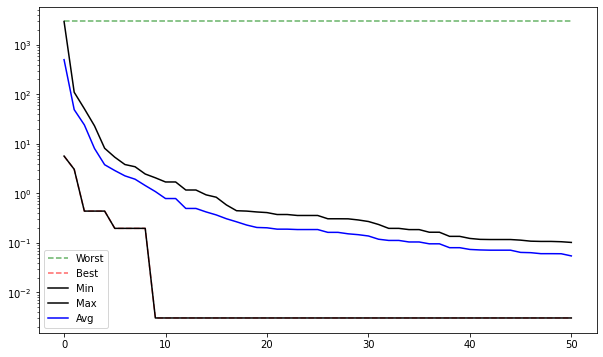

In [2]:
from EAOS.fnevaluator import FnEvaluator
from EAOS.generators import RandomUniform
from EAOS.monitor import Monitor
from EAOS.operators import MutationEP, SelectionBest

#
# Parámetros
# =======================================================================
#
NGEN = 50
POPSIZE = 20

#
# Operadores genéticos
# =======================================================================
#
generate_population = RandomUniform(
    popsize=POPSIZE,
    low=fn.LB,
    high=fn.UB,
    seed=123456,
)

evaluate = FnEvaluator(fn=fn)
mutate = MutationEP(
    beta=0.01,
    gamma=0.1,
    seed=123456,
)
select_best = SelectionBest(k=POPSIZE)
monitor = Monitor()

#
# Algoritmo
# =======================================================================
#
population = generate_population()
population = evaluate(population)
monitor(population)

for _ in range(NGEN):

    offsprings = mutate(population)
    offsprings = evaluate(offsprings)
    population = select_best(population + offsprings)
    monitor(population)


monitor.plot_stats()

In [3]:
fn.plot_trayectory(monitor)

In [4]:
monitor.global_x_opt, monitor.global_fn_x_opt

(array([0.94604161, 0.89378074]), 0.0030588868532314697)

## Algoritmo MetaEP

In [5]:
import numpy as np
from EAOS.fnevaluator import FnEvaluator
from EAOS.generators import RandomUniform
from EAOS.monitor import Monitor
from EAOS.operators import Mapper, MutationMetaEP, SelectionBest

#
# Parámetros
# =======================================================================
#
NGEN = 50
POPSIZE = 20

#
# Operadores genéticos
# =======================================================================
#
generate_population = RandomUniform(
    popsize=POPSIZE,
    low=fn.LB,
    high=fn.UB,
    seed=123456,
)

# Función que se aplica a cada individuo de la población
rng = np.random.default_rng(12345)


def mapfn(individual):
    individual["EP_sigma"] = rng.uniform(low=0.4, high=0.9, size=2)
    return individual


mapper = Mapper(fn=mapfn)
evaluate = FnEvaluator(fn=fn)
mutate = MutationMetaEP(
    c=1.0,
    sigma_min=1e-4,
    sigma_max=4,
    seed=123456,
)
select_best = SelectionBest(k=POPSIZE)
monitor = Monitor()

#
# Algoritmo
# =======================================================================
#
population = generate_population()
population = mapper(population)
population = evaluate(population)
monitor(population)

for _ in range(NGEN):

    offsprings = mutate(population)
    offsprings = evaluate(offsprings)
    population = select_best(population + offsprings)
    monitor(population)


monitor.plot_stats()

In [6]:
monitor.global_x_opt, monitor.global_fn_x_opt

(array([0.94282822, 0.88843556]), 0.0032925728529870713)

## Experimento: Comparación entre EP y MetaEP

In [7]:
from EAOS.monitor import plot_performance

NDIM = 20
NGEN = 50
POPSIZE = 50
NRUNS = 20

fn_griewank = Griewank(n_dim=NDIM)
fn_ackley = Ackley(n_dim=NDIM)

select_best = SelectionBest(k=POPSIZE)


def mapfn(individual):
    individual["EP_sigma"] = rng.uniform(low=0.4, high=0.9, size=NDIM)
    return individual


mapper = Mapper(fn=mapfn)


def run(fn):

    monitors = []

    for i_run in range(2):

        evaluate = FnEvaluator(fn=fn)

        generate_population = RandomUniform(
            popsize=POPSIZE,
            low=fn.LB,
            high=fn.UB,
            seed=123456,
        )

        beta = (fn.UB[0] - fn.LB[0]) / 10.0

        if i_run == 0:

            mutate = MutationEP(
                beta=beta,
                gamma=0.0,
                seed=123456,
            )

        else:

            mutate = MutationMetaEP(
                c=1.0,
                sigma_min=beta / 10.0,
                sigma_max=1000,
                seed=123456,
            )

        monitor = Monitor()

        for i_run in range(NRUNS):

            monitor.new_run()

            population = generate_population()
            population = mapper(population)
            population = evaluate(population)
            monitor(population)

            for _ in range(NGEN):

                offsprings = mutate(population)
                offsprings = evaluate(offsprings)
                population = select_best(population + offsprings)
                monitor(population)

        monitors.append(monitor)

    plot_performance(monitors, legends=["EP", "MetaEP"])

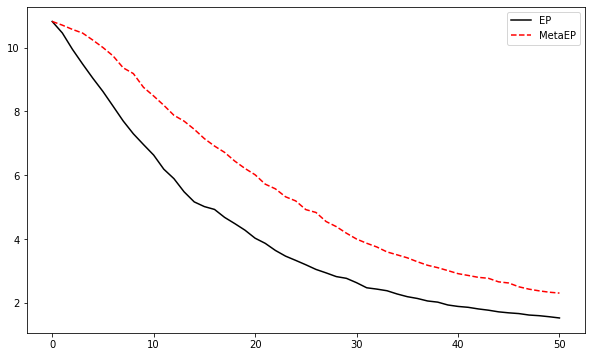

In [8]:
run(fn_griewank)

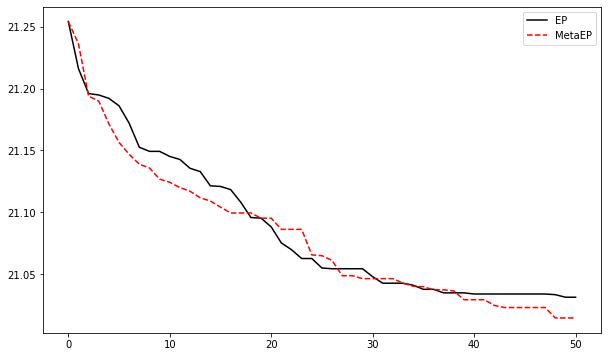

In [9]:
run(fn_ackley)